### Section 7.2 part 2

In this part of the experiment we consider fixed (p, q) in case where they 

In [1]:
%load_ext autoreload
%reload_ext autoreload

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import cf.gadget_2_jax as JP_Z
from cf import utils
from cf import models


In [3]:
def train_gsm_with_gadget1(num_epochs, model, logits_p, logits_q, R, lr=0.001, tau=1.0, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=schedualer_decay)
    bs = 64

    losses = []
    l_avg = []

    k = logits_p.size(-1)

    RiRj = torch.tensor([(R(i) - R(j)) ** 2 for i in range(k) for j in range(k)])  # /normalizer
    RiRj = RiRj.view(1, k, k).repeat([bs, 1, 1])

    ma_l, ma_c = 0, 0
    logits_p = logits_p.repeat([bs, 1])
    logits_q = logits_q.repeat([bs, 1])

    for epoch in range(num_epochs):
        p, q = add_noise_if_generalized_pq(logits_p, logits_q, GENERALIZED)
        
        bs = p.size(0)
        u = torch.rand(bs, p.size(-1), q.size(-1))
        joint_pq = model(p, is_pq=True)
        joint_qp = model(q, is_pq=False)


        gumbel_noise = - torch.log(1e-8 - torch.log(u + 1e-8))
        logprobs_p = utils.marginal_gumbel_log_softmax(joint_pq, gumbel_noise, rows=True, tau=tau, hard=False)
        logprobs_q = utils.marginal_gumbel_log_softmax(joint_qp, gumbel_noise.transpose(-2, -1), rows=True, tau=tau,
                                                    hard=False)

        covariance = torch.exp(logprobs_p[:, :, None] + logprobs_q[:, None, :]) * RiRj.view(bs, k, k)

        loss = torch.sum((logprobs_p[:, :, None] + logprobs_q[:, None, :]) * covariance.detach())

        l_avg.append((loss.item(), covariance.sum().item()))

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            lr_scheduler.step() if schedualer_decay != 1.0 else None
            tau = tau * tau_decay

        if epoch % 50 == 0 or np.remainder(np.log2(epoch), 1) == 0:
            l, c = zip(*l_avg)
            l, c = np.mean(l), np.mean(c)
            losses.append((l, c))
            l_avg = []
            ma_l = .99 * ma_l + .01 * l
            ma_c = .99 * ma_c + .01 * c
            if verbose:
                print(f'{epoch} {tau} {l} {c}')

    return losses



In [4]:
def train_gsm_with_gadget2(num_epochs, model, logits_p, logits_q, reward_f, s_prime_obs=None, cf=False,
                            verbose=True, seed=0):
    if cf:
        assert s_prime_obs is not None, 's_prime_obs must be given in the CF method'
    else:
        #set dummy s_prime
        s_prime_obs = 0

    logits_p = logits_p.numpy().clip(min=-80.0)
    logits_q = logits_q.numpy().clip(min=-80.0)
    k = logits_p.shape[-1]

    rewards = np.array([reward_f(i) for i in range(k)])

    model.train(logits_p, logits_q,
                np.array(s_prime_obs), rewards, num_iter=num_epochs,
                cf=cf, noise_scale=GENERALIZED, verbose=verbose, seed=seed)
    

In [5]:
def add_noise_if_generalized_pq(p, q, std):
    # add noise to logits    
    if std != 0:
        return torch.clamp(p + std*torch.randn_like(p), max=0.0), torch.clamp(q + std*torch.randn_like(q), max=0.0)
    else:
        return p, q

In [6]:

# Non-monotonic reward function
def R_sin(a, s=None):
    return np.sin(15 * a)


def R_sin30(a, s=None):
    return np.sin(30 * a)


def R_random_sin30(a, s=None):
    return RANDOM_NON_MONOTONE_R[a]


# Monotonic (in the region)
def R_random(a, s=None):
    return RANDOM_MONOTONE_R[a] 


def R_sqr(a, s=None):
    return a ** 2


In [7]:

R_monotone = R_random
R_non_monotone = R_random_sin30

#figpath = "./figs/toy_example"
figpath = "figs/"
coupler_save_path = R_monotone.__name__ + '-' + R_non_monotone.__name__

In [8]:
def create_random_monotone():
    return np.cumsum(np.random.rand(K))

def create_random_non_monotone():
    return R_sin30(np.random.normal(loc=np.zeros(K), scale=1))


In [9]:
K = 10

schedualer_decay = 1.0
tau_decay = 1.0
learning_rate = 0.00001

torch.manual_seed(100)
np.random.seed(100)

    
RANDOM_MONOTONE_R = create_random_monotone()
RANDOM_NON_MONOTONE_R = create_random_non_monotone()

GENERALIZED = 0
p_logits = (torch.arange(K, 0, step=-1).float()/4).unsqueeze(0)
q_logits = (torch.arange(K).float()/4).unsqueeze(0)


In [10]:
gd1_non_monotone = models.JointPredictorGivenLogits(K, 1024)
gd2_non_monotone = JP_Z.Gadget2Jax(s_dim=K, z_dim=20, hidden_features=[1024,1024], tmp=1.0)

#
train_gsm_with_gadget1(2000, gd1_non_monotone, p_logits, q_logits, R_non_monotone, tau=1.0, lr=learning_rate)
train_gsm_with_gadget2(2000, gd2_non_monotone, p_logits, q_logits, R_non_monotone, s_prime_obs=None)


0 1.0 -167.9389398643856 52.324004913466865
1 1.0 -155.5490832190536 58.144065714950116
2 1.0 -175.50655121120153 59.31430416194602
4 1.0 -174.3931358170284 57.931231495763356
8 1.0 -171.2437877525198 56.5110724927502
16 1.0 -166.5353348913696 55.54475491220046
32 1.0 -168.85153891476392 57.14526575097915
50 1.0 -169.4767376565317 55.98763226258352
64 1.0 -169.31475324757358 55.113062645211464
100 1.0 -164.41959151759173 54.019143479658695
128 1.0 -165.26732003016073 53.82468731915931
150 1.0 -165.04225421833783 51.671158613726725
200 1.0 -163.61047298397025 51.035025649660696
250 1.0 -161.26902005378014 50.115249191829996
256 1.0 -159.01353535161397 48.389123530846824
300 1.0 -159.76142380584668 48.23573796995071
350 1.0 -160.69120360056476 47.56453717837677
400 1.0 -158.93637818423574 46.71928901230769
450 1.0 -157.81276452439903 46.53609680013909
500 1.0 -158.0909916578559 45.89234425061499
512 1.0 -157.43416324083364 45.26634913084891
550 1.0 -158.1204285643671 45.74081610857735
60

In [11]:

gd1_monotone = models.JointPredictorGivenLogits(K, 1024)
gd2_monotone = JP_Z.Gadget2Jax(s_dim=K, z_dim=20, hidden_features=[1024,1024], tmp=1.0)

train_gsm_with_gadget1(2000, gd1_monotone, p_logits, q_logits, R_monotone, tau=1.0, lr=learning_rate)
train_gsm_with_gadget2(2000, gd2_monotone, p_logits, q_logits, R_monotone, s_prime_obs=None)



0 1.0 -708.3702203004975 257.28724122019713
1 1.0 -714.2217068482007 290.8004172156075
2 1.0 -753.3472956603676 299.76778768428403
4 1.0 -708.1431515712784 258.0230642630415
8 1.0 -730.0606884518941 272.48550828098683
16 1.0 -746.6774640116587 265.24287909825273
32 1.0 -727.4646328265603 268.18615157844954
50 1.0 -728.1139133561257 268.38696042390285
64 1.0 -721.2240044477591 265.44342458868744
100 1.0 -742.7275416705138 276.1595332724956
128 1.0 -738.357437253195 266.94377085422633
150 1.0 -738.2012007359391 263.8609905896301
200 1.0 -734.4423230492101 262.83799644136997
250 1.0 -726.378975315848 257.9427140494324
256 1.0 -717.7958512069263 255.59375785658526
300 1.0 -718.2819254039861 252.68372884570383
350 1.0 -712.2109944213058 250.38463151719677
400 1.0 -711.2767435224341 250.20797012678813
450 1.0 -714.559915158114 245.85613786038687
500 1.0 -717.3158270961245 249.63337041872532
512 1.0 -701.2417934659508 238.98988057754005
550 1.0 -711.2260216975068 245.21129744098857
600 1.0 -7

Let's compare our joint predictor to Gumbel-Max and inverseCDF coupling:

In [12]:
def f_gumbel(u, logits):
    # u is a vector of size size(logits)
    return torch.argmax(-torch.log(-torch.log(u)) + logits)


def f_cdf_inv(u, logits):
    u = u[0]
    cum = 0
    for i, p in zip(torch.arange(logits.size(-1)), torch.softmax(logits, dim=-1)):
        cum += p
        if cum > u:
            return i


def get_couple(f, logits_p, logits_q, r, antithetic=False, indep=False):
    u = torch.rand_like(logits_p)
    ap = f(u, logits_p)
    
    if not indep:
        aq = f(u, logits_q) if not antithetic else f(1 - u, logits_q)
    else:
        aq = f(torch.rand_like(logits_p), logits_q)

    rp = r(ap)
    rq = r(aq)

    return (ap.item(), aq.item()), (rp - rq).item()

In [13]:
from scipy.optimize import linprog


class MaxCovSolver:
    def __init__(self, logits, r):
        p_logits, q_logits = logits
        probs_p = torch.softmax(p_logits, dim=-1).detach().numpy()
        probs_q = torch.softmax(q_logits, dim=-1).detach().numpy()

        self.obj = lambda r1, r2: (r1 - r2)**2

        self.K = len(probs_p)
        assert self.K == len(probs_q)

        self.ij_to_idx = {(i, j): i * self.K + j for i in range(self.K) for j in range(self.K)}
        self.idx_to_ij = {i * self.K + j: (i, j) for i in range(self.K) for j in range(self.K)}

        self.bnd = [(0.0, 1.0) for i in range(self.K) for j in range(self.K)]
        self.lhs, self.rhs = self.create_constrains(probs_p, probs_q)
        self.psi_obj = self.create_obj(r)

        np.set_printoptions(threshold=np.inf)


    def __call__(self, method="simplex", tol=1.4e-07):
        self.opt = linprog(c=self.psi_obj,
                           A_eq=self.lhs,
                           b_eq=self.rhs,
                           bounds=self.bnd,
                           method=method,
                           options={'ipm_optimality_tolerance': 1e-12,
                                    'dual_feasibility_tolerance':1e-10,
                                    'primal_feasibility_tolerance':1e-10}
                           #options={'rr': False, 'tol': tol}  # , 'autoscale':True
                           )
        return self.opt.x

    def get_opt_coupling(self):
        """returns (a_p, a_q, prob)"""
        return [(self.idx_to_ij[m][0], self.idx_to_ij[m][1], aij) for m, aij in enumerate(self.opt.x)]

    def create_obj(self, r):
        obj = [0 for _ in range(self.K) for _ in range(self.K)]
        for i in range(self.K):
            for j in range(self.K):
                obj[self.ij_to_idx[(i, j)]] = self.obj(r(i), r(j))  #(r(i)-r(j))**2 #-r(i)*r(j)
        return obj

    def create_constrains(self, p, q):
        K = self.K
        lhs = [[0 for _ in range(K * K)] for __ in range(2 * K)]
        rhs = []
        for i, eq in enumerate(lhs):
            for k1 in range(K):
                for k2 in range(K):
                    if i == k1:
                        lhs[i][self.ij_to_idx[(k1, k2)]] = 1

                    elif i - K == k1:
                        lhs[i][self.ij_to_idx[(k2, k1)]] = 1
                if i == k1:
                    rhs.append(p[k1])
                elif i - K == k1:
                    rhs.append(q[k1])

        return lhs, rhs


In [14]:
def sample_from_joint(joint_pq, joint_qp, r):
    u = torch.rand_like(joint_pq)  # bs, k, k
    gumbel_noise = - torch.log(1e-8 - torch.log(u + 1e-8))
    ap = utils.marginal_gumbel_log_softmax(joint_pq, gumbel_noise, rows=True, tau=1.0).argmax(-1)
    aq = utils.marginal_gumbel_log_softmax(joint_qp, gumbel_noise.transpose(-2, -1), rows=True, tau=1.0).argmax(-1)

    rp = r(ap).squeeze()
    rq = r(aq).squeeze()

    return (ap.item(), aq.item()), (rp - rq).item()


def sample_from_policy(model, logits_p, logits_q, r):
    joint_pq = model(logits_p.view(1, logits_p.size(-1)), is_pq=True)
    joint_qp = model(logits_q.view(1, logits_p.size(-1)), is_pq=False)

    return sample_from_joint(joint_pq, joint_qp, r)


def get_opt_joint(logits_p, logits_q, r):
    m = MaxCovSolver(logits=(logits_p, logits_q), r=r)
    sol = m(method='highs-ipm') #, tol=1.4e-6)  #"interior-point", revised simplex,highs-ipm
    #print(m.opt)
    _, _, probs_opt = zip(*m.get_opt_coupling())
    -m.opt.fun
    k = logits_p.size(-1)
    return torch.tensor(probs_opt).log().reshape(1, k, k)


In [15]:

def compare_coupling_strategies(n, p_logits, q_logits, R, model, model_z, params_z, monotone=False):
    logits_pq_opt = get_opt_joint(p_logits, q_logits, R) if not monotone else None
    ates = []
    couples = []
    r = np.array([R(i) for i in range(q_logits.shape[-1])])
    for i in range(n):
        # Independant 
        (ap_i, aq_i), ate_i = get_couple(f_gumbel, p_logits, q_logits, R, indep=True)
        
        # Gumbel-Max
        (ap_g, aq_g), ate_g = get_couple(f_gumbel, p_logits, q_logits, R)

        # Inverse CDF
        (ap_c, aq_c), ate_c = get_couple(f_cdf_inv, p_logits, q_logits, R)

        # Joint Predictor - gadget 1
        (ap_m, aq_m), ate_m = sample_from_policy(model, p_logits, q_logits, R)

        # Joint Predictor - gadget 2        
        (ap_z, aq_z), ate_z = JP_Z.get_single_ate(model_z, params_z, p_logits, q_logits, r, i, p_observed=None,
                                                  method='crn')

        # Optimal Coupling
        if not monotone:            
            (ap_o, aq_o), ate_o = sample_from_joint(logits_pq_opt, logits_pq_opt.transpose(-2, -1), R)
        else:
            # The Inverse-cdf is optimal under monotone functions (see the paper). 
            (ap_o, aq_o), ate_o = (ap_c, aq_c), ate_c

        ates.append((ate_i, ate_g, ate_c, ate_m, ate_z, ate_o))
        couples.append(((ap_i, aq_i), (ap_g, aq_g), (ap_c, aq_c), (ap_m, aq_m), (ap_z, aq_z), (ap_o, aq_o)))

    return ates, couples



In [16]:

n = 1000
p_logits, q_logits = p_logits.squeeze(0), q_logits.squeeze(0)

ates_monotone, couples_monotone = compare_coupling_strategies(n, p_logits, q_logits, R_monotone,
                                                              gd1_monotone, gd2_monotone.model,
                                                              gd2_monotone.params, monotone=True)

ates_nonmonotone, couples_nonmonotone = compare_coupling_strategies(n, p_logits, q_logits, R_non_monotone,
                                                                    gd1_non_monotone, gd2_non_monotone.model,
                                                                    gd2_non_monotone.params, monotone=False)



In [17]:
def joint_from_samples(couples, size=10):
    counts = np.zeros((size,size))
    for (ap,aq) in couples:
        counts[ap, aq] += 1.0

    joint = counts/len(couples)
    return joint



In [18]:
import matplotlib.ticker as plticker
def visualize_couplings(couples, logits_1, logits_2, R, suffix=''):
    ai, ag, ac, am, az, ao = zip(*couples)
    k = logits_1.shape[-1]
    RiRj = np.array([(R(i) - R(j)) ** 2 for i in range(k) for j in range(k)]).reshape(k,k)
    independent_coupling = torch.softmax(torch.from_numpy(logits_1),-1)[:, None] * torch.softmax(torch.from_numpy(logits_2),-1)[None, :]
    gmx = joint_from_samples(ag, k)
    icdf = joint_from_samples(ac, k)
    jp = joint_from_samples(am, k)
    jpz = joint_from_samples(az, k)
    opt = joint_from_samples(ao, k)


    couplings = {
        "Independent": independent_coupling,
        "Gumbel-max": gmx,
        "Inverse-CDF": icdf,
        "Gadget-1": jp,
        "Gadget-2": jpz,
        "optimal coupling": opt,
    }
    
    loc = plticker.MultipleLocator(base=2.0)
    ncols = 2 + len(couplings)
    _, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4))
    axs[0].imshow(np.exp(logits_1)[:, None], vmin=0)
    axs[1].imshow(np.exp(logits_2)[:, None], vmin=0)
    for j, (name, coupling) in enumerate(couplings.items()):
        axs[j + 2].xaxis.set_major_locator(loc)
        axs[j + 2].imshow(coupling, vmin=0)
        if name == 'Independent':
            axs[j + 2].set_title(f"{name}:\n{torch.sum(coupling * torch.tensor(RiRj)).item():.2f}",  fontsize = 18)

        else:
            axs[j + 2].set_title(f"{name}:\n{np.sum(coupling * RiRj):.2f}",  fontsize = 18)
            

    plt.savefig("{}/toy_couples_{}_{}.pdf".format(figpath, coupler_save_path, suffix), bbox_inches='tight')


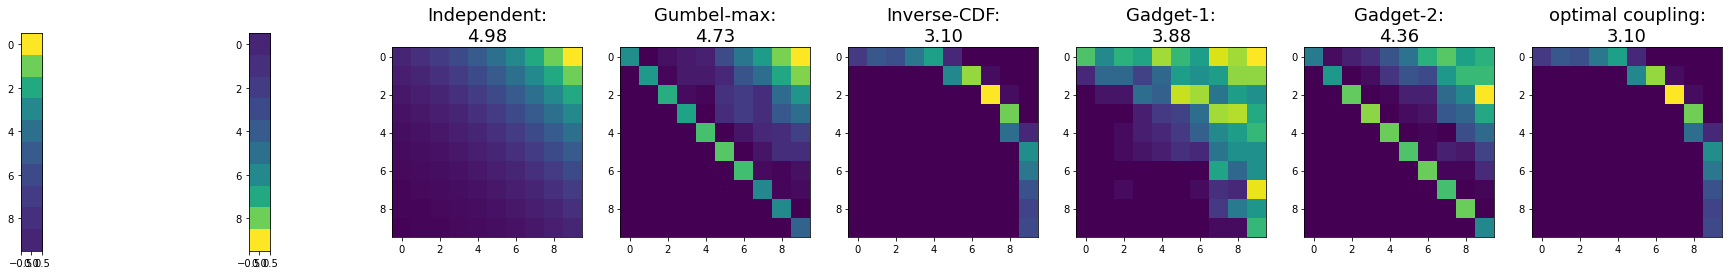

In [19]:
visualize_couplings(couples_monotone, p_logits.numpy(), q_logits.numpy(), R_monotone, suffix='R_monotone')

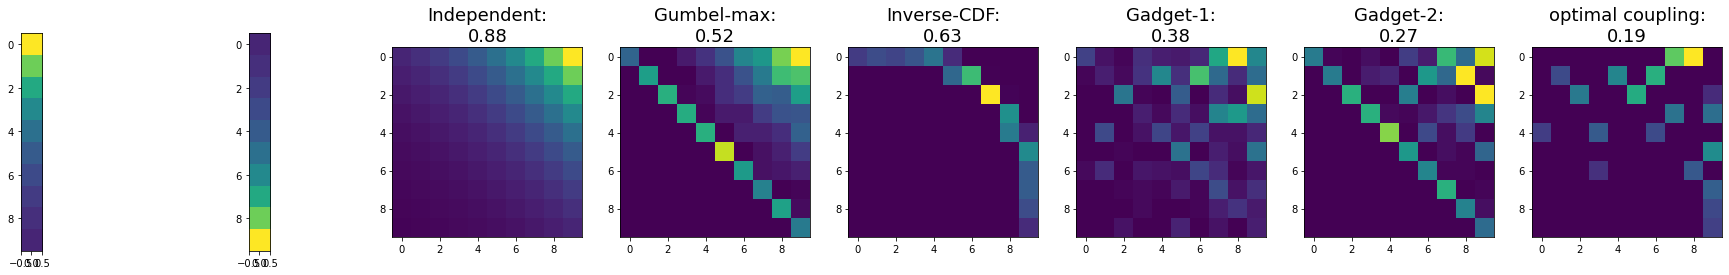

In [20]:
visualize_couplings(couples_nonmonotone, p_logits.numpy(), q_logits.numpy(), R_non_monotone, suffix='R_non_monotone')

In [21]:
var_mono = {'indep': [],
            'gmx': [],
            'icdf': [],
            'jp': [],
            'jpz': [],
            'opt': []
            }

var_nonmono = {'indep': [],
               'gmx': [],
               'icdf': [],
               'jp': [],
               'jpz': [],
               'opt': []
               }
for trial in range(10):
    print('-------  trial: ', trial, '-----------')
    torch.manual_seed(trial)
    np.random.seed(trial)
    RANDOM_MONOTONE_R = create_random_monotone()
    RANDOM_NON_MONOTONE_R = create_random_non_monotone()

    p_logits = (torch.arange(K, 0, step=-1).float()/4).unsqueeze(0)
    q_logits = (torch.arange(K).float()/4 ).unsqueeze(0)

    gd1_non_monotone = models.JointPredictorGivenLogits(K, 1024)
    gd2_non_monotone = JP_Z.Gadget2Jax(s_dim=K, z_dim=20, hidden_features=[1024,1024], tmp=1.0)

    train_gsm_with_gadget1(3000, gd1_non_monotone, p_logits, q_logits, R_non_monotone, tau=1.0,
                           lr=learning_rate,verbose=False)
    train_gsm_with_gadget2(3000, gd2_non_monotone, p_logits, q_logits, R_non_monotone, s_prime_obs=None,
                           verbose=False, seed=trial)

    gd1_monotone = models.JointPredictorGivenLogits(K, 1024) #models.FreeParamsPredictor(K)
    gd2_monotone = JP_Z.Gadget2Jax(s_dim=K, z_dim=20, hidden_features=[1024,1024], tmp=1.0)

    train_gsm_with_gadget1(3000, gd1_monotone, p_logits, q_logits, R_monotone, tau=1.0, lr=learning_rate, verbose=False)
    train_gsm_with_gadget2(3000, gd2_monotone, p_logits, q_logits, R_monotone, s_prime_obs=None,
                            verbose=False, seed=trial)

    n = 2000
    p_logits, q_logits = p_logits.squeeze(0), q_logits.squeeze(0)

    #### plot R(a) = np.cumsum(np.random.rand(K))[a] ###
    ates, _ = compare_coupling_strategies(n, p_logits, q_logits, R_monotone,
                                          gd1_monotone, gd2_monotone.model,
                                          gd2_monotone.params, monotone=True)
    ate_i, ate_g, ate_c, ate_m, ate_z, ate_o = zip(*ates)

    var_mono['indep'].append(np.var(ate_i))
    var_mono['gmx'].append(np.var(ate_g))
    var_mono['icdf'].append(np.var(ate_c))
    var_mono['jp'].append(np.var(ate_m))
    var_mono['jpz'].append(np.var(ate_z))
    var_mono['opt'].append(np.var(ate_o))
    print('Monotonic reward function:')
    print(f" indep: {var_mono['indep'][-1]}, gmx: {var_mono['gmx'][-1]},  icdf: {var_mono['icdf'][-1]},"
          f" jp: {var_mono['jp'][-1]}, jpz: {var_mono['jpz'][-1]},  opt: {var_mono['opt'][-1]}")
    
    
    #### plot R(a) = sin(30*(np.random.normal(loc=np.zeros(K), scale=1)))[a] ###
    ates, _ = compare_coupling_strategies(n, p_logits, q_logits, R_non_monotone,
                                          gd1_non_monotone, gd2_non_monotone.model,
                                          gd2_non_monotone.params, monotone=False)
    ate_i, ate_g, ate_c, ate_m, ate_z, ate_o = zip(*ates)

    var_nonmono['indep'].append(np.var(ate_i))
    var_nonmono['gmx'].append(np.var(ate_g))
    var_nonmono['icdf'].append(np.var(ate_c))
    var_nonmono['jp'].append(np.var(ate_m))
    var_nonmono['jpz'].append(np.var(ate_z))
    var_nonmono['opt'].append(np.var(ate_o))
    print('Non-monotonic reward function:')
    print(f" indep: {var_nonmono['indep'][-1]}, gmx: {var_nonmono['gmx'][-1]},  icdf: {var_nonmono['icdf'][-1]},"
          f" jp: {var_nonmono['jp'][-1]}, jpz: {var_nonmono['jpz'][-1]},  opt: {var_nonmono['opt'][-1]}")

-------  trial:  0 -----------
Monotonic reward function:
 indep: 4.945008733341747, gmx: 4.317262516278003,  icdf: 0.8556931297995052, jp: 2.5089839048180056, jpz: 3.556820869445801,  opt: 0.8556931297995052
Non-monotonic reward function:
 indep: 0.5155141654030311, gmx: 0.27721546732525076,  icdf: 0.537890074085093, jp: 0.13227421161822375, jpz: 0.13969506323337555,  opt: 0.033353026616698034
-------  trial:  1 -----------
Monotonic reward function:
 indep: 0.9346426465980064, gmx: 0.8546105420829483,  icdf: 0.11761825901602112, jp: 0.42962005012723403, jpz: 0.5831938982009888,  opt: 0.11761825901602112
Non-monotonic reward function:
 indep: 0.9601617302853735, gmx: 0.6535214406187828,  icdf: 1.2309370924190854, jp: 0.3053650809559505, jpz: 0.17960374057292938,  opt: 0.08596162860123933
-------  trial:  2 -----------
Monotonic reward function:
 indep: 1.8068711050510027, gmx: 1.5260233996375931,  icdf: 0.41109068922261677, jp: 0.8936223986409814, jpz: 1.2781264781951904,  opt: 0.4110

In [22]:
import seaborn as sns
import pandas as pd


def conv_to_np(this_list):
    this_arr = np.array(this_list)[:, np.newaxis]
    # Make this idempotent
    this_arr = this_arr.squeeze()[:, np.newaxis]
    return this_arr

In [23]:
def plot_ate_var(variance, title='Monotonic R'):
    gmx = conv_to_np(variance['gmx'])
    icdf = conv_to_np(variance['icdf'])
    #anti = conv_to_np(variance['anti'])
    jp = conv_to_np(variance['jp'])
    jpz = conv_to_np(variance['jpz'])
    opt = conv_to_np(variance['opt'])

    plt.rcParams.update({'font.size': 14})
    reward = np.concatenate([gmx,
                             icdf,
                             #anti,
                             jp,
                             jpz,
                             opt,
                             ], axis=1)
    reward_df = pd.DataFrame(reward, columns=['Gumbel-Max',
                                              'Inverse-CDF',
                                              #'Antithetic',
                                              'Gadget-1',
                                              'Gadget-2',
                                              'Optimal (LP)'
                                              ])

    plt.figure(figsize=(8, 5))
    #sns.boxplot(data=reward_df, whis=[2.5, 97.5])
    sns.barplot(data=reward_df, ci=68)
    plt.title(title)
    plt.ylabel("ATE variance")
    plt.savefig("{}/toy_ate_var_{}_{}.pdf".format(figpath, coupler_save_path, title))

    plt.show()

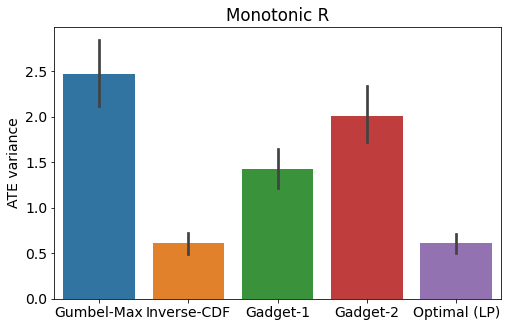

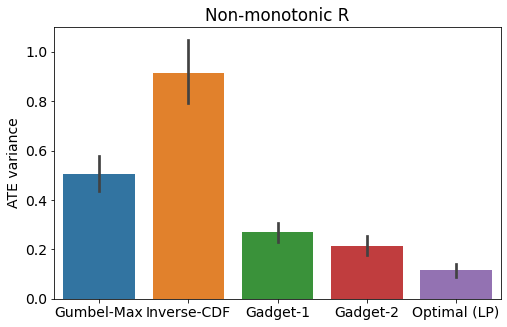

In [24]:
plot_ate_var(var_mono, title='Monotonic R')
plot_ate_var(var_nonmono, title='Non-monotonic R')



In [25]:
print("monotone:")
sqrt_length = np.sqrt(len(var_mono['gmx']))
print("indep:", np.mean(var_mono['indep']), np.std(var_mono['indep'])/sqrt_length)
print("gmx:", np.mean(var_mono['gmx']), np.std(var_mono['gmx'])/sqrt_length)
print("icdf:", np.mean(var_mono['icdf']), np.std(var_mono['icdf'])/sqrt_length)
print("opt:", np.mean(var_mono['opt']), np.std(var_mono['opt'])/sqrt_length)
print("gadget-1:", np.mean(var_mono['jp']), np.std(var_mono['jp'])/sqrt_length)
print("gadget-2:", np.mean(var_mono['jpz']), np.std(var_mono['jpz'])/sqrt_length)


monotone:
indep: 2.733486489809488 0.3913439631449939
gmx: 2.4667295565595384 0.35167200462405224
icdf: 0.6081048167483316 0.10889778343050012
opt: 0.6081048167483316 0.10889778343050012
gadget-1: 1.4268250666989728 0.22174222145468936
gadget-2: 2.0025127 0.3010683485305203


In [26]:
print("non-monotone:")
sqrt_length = np.sqrt(len(var_nonmono['gmx']))
print("indep:", np.mean(var_nonmono['indep']), np.std(var_nonmono['indep'])/sqrt_length)
print("gmx:", np.mean(var_nonmono['gmx']), np.std(var_nonmono['gmx'])/sqrt_length)
print("icdf:", np.mean(var_nonmono['icdf']), np.std(var_nonmono['icdf'])/sqrt_length)
print("opt:", np.mean(var_nonmono['opt']), np.std(var_nonmono['opt'])/sqrt_length)
print("gadget-1:", np.mean(var_nonmono['jp']), np.std(var_nonmono['jp'])/sqrt_length)
print("gadget-2:", np.mean(var_nonmono['jpz']), np.std(var_nonmono['jpz'])/sqrt_length)


non-monotone:
indep: 0.834538600419416 0.10410340659394125
gmx: 0.5068929387904362 0.06618207663718108
icdf: 0.9119719070902205 0.12953292939956165
opt: 0.11582219665192553 0.02799775553045251
gadget-1: 0.2689475769701155 0.03697646188685072
gadget-2: 0.21554239 0.037788736229982856
